In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import time

# Scrape all available years of data and combine

In [2]:
def get_data(year):
    
    time.sleep(0.5)
    
    # set urls
    rush_url = f'https://www.pro-football-reference.com/years/{year}/rushing.htm'
    receiving_url = f'https://www.pro-football-reference.com/years/{year}/receiving.htm'
    
    # get rushing data
    res = requests.get(rush_url, allow_redirects=False)
    soup = BeautifulSoup(res.content, "lxml")
    table = soup.find('table', {'id':'rushing'})
    rushing = pd.read_html(str(table))[0]
    rushing.columns = rushing.columns.droplevel(0)
    rushing.Player.replace('[^a-zA-Z0-9_ ]','',regex=True, inplace=True)
    rushing.drop(columns=['Lng', 'Y/A', 'Y/G', 'Tm', 'Rk'], inplace=True)
    rushing.rename(columns={'Att': 'rush_att', 'Yds': 'rush_yds', 'TD': 'rush_td'}, inplace=True)
    rushing['year'] = year
    
    # get receiving data
    res = requests.get(receiving_url, allow_redirects=False)
    soup = BeautifulSoup(res.content, "lxml")
    table = soup.find('table', {'id':'receiving'})
    receiving = pd.read_html(str(table))[0]
    try:
        receiving.columns = receiving.columns.droplevel(0)
    except:
        pass

    receiving.Player.replace('[^a-zA-Z0-9_ ]','',regex=True, inplace=True)
    receiving.drop(columns=['Lng', 'Y/R', 'Y/Tgt', 'R/G', 'Y/G', 'Tm', 'Rk'], inplace=True)
    receiving.rename(columns={'Rec': 'receiving_att', 'Yds': 'receiving_yds', 'TD': 'receiving_td'}, inplace=True)
    receiving['year'] = year
    
    # merge data
    receiving_merge = receiving[['Player', 'receiving_att', 'receiving_yds', 'receiving_td']]
    df = rushing.merge(receiving_merge, on='Player', how='left')
    
    # Drop rows that contain the extra column labels or nan
    df = df[df.Player != 'Player']
    df.dropna(inplace=True)
    
    # Remove all non running backs
    drop_positions = ['FB', 'fb', 'QB', 'WR', 'qb', 'wr', 'LCB', 'LDT', 'TE', 'RCB', 'te', 'RT', 'rcb', 'B', '/qb', '/fb', '/wr']
    df = df[~df.Pos.isin(drop_positions)]
    
    return df

In [3]:
# Scrape the data for all years listed or load if already saved
try:
    df = pd.read_csv('./data/running_back_touches_study.csv')
except:
    years = np.arange(1975,2022,1)

    dfs = [get_data(year) for year in years]
    df = pd.concat(dfs)
    df.drop(columns='1D', inplace=True)

In [4]:
df.head(5)

,Player,Age,Pos,G,GS,rush_att,rush_yds,rush_td,Fmb,year,receiving_att,receiving_yds,receiving_td
0,OJ Simpson,28,RB,14,14,329,1817,16,7,1975,28,426,7
1,Lydell Mitchell,26,RB,14,14,289,1193,11,5,1975,60,544,4
2,Chuck Foreman,25,RB,14,12,280,1070,13,12,1975,73,691,9
3,Mike Thomas,22,RB,14,10,235,919,4,9,1975,40,483,3
4,Mercury Morris,28,RB,14,14,219,875,4,5,1975,2,15,0


In [5]:
df.to_csv('./data/running_back_touches_study.csv', index=False)

# Process the data 

In [6]:
df[['G', 'GS', 'rush_att', 'rush_yds', 'rush_td', 'Fmb', 'year', 'receiving_att', 'receiving_yds', 'receiving_td']] = df[['G', 'GS', 'rush_att', 'rush_yds', 'rush_td', 'Fmb', 'year', 'receiving_att', 'receiving_yds', 'receiving_td']].astype(int)

In [7]:
# add total touches and games missed
df['total_touches'] = df.rush_att + df.receiving_att
df['games_missed'] = np.where(df.year > 1978,
                              np.where(df.year < 2021, 16-df.G, 17-df.G),
                              14-df.G
                              )
df.head()

,Player,Age,Pos,G,GS,rush_att,rush_yds,rush_td,Fmb,year,receiving_att,receiving_yds,receiving_td,total_touches,games_missed
0,OJ Simpson,28,RB,14,14,329,1817,16,7,1975,28,426,7,357,0
1,Lydell Mitchell,26,RB,14,14,289,1193,11,5,1975,60,544,4,349,0
2,Chuck Foreman,25,RB,14,12,280,1070,13,12,1975,73,691,9,353,0
3,Mike Thomas,22,RB,14,10,235,919,4,9,1975,40,483,3,275,0
4,Mercury Morris,28,RB,14,14,219,875,4,5,1975,2,15,0,221,0


In [8]:
# Add fantasy points
def fantasy_points(row):
    fantasy_points_dict = {'rush_yds': 0.1,
                        'rush_td': 6,
                        'Fmb': -2,
                        'receiving_att': 1,
                        'receiving_yds': 0.1,
                        'receiving_td': 6}
    fantasy_points = 0
    for key, value in fantasy_points_dict.items():
        fantasy_points += row[key] * value
    
    return fantasy_points

df['fantasy_points'] = df.apply(fantasy_points, axis=1)
df.head()

,Player,Age,Pos,G,GS,rush_att,rush_yds,rush_td,Fmb,year,receiving_att,receiving_yds,receiving_td,total_touches,games_missed,fantasy_points
0,OJ Simpson,28,RB,14,14,329,1817,16,7,1975,28,426,7,357,0,376.3
1,Lydell Mitchell,26,RB,14,14,289,1193,11,5,1975,60,544,4,349,0,313.7
2,Chuck Foreman,25,RB,14,12,280,1070,13,12,1975,73,691,9,353,0,357.1
3,Mike Thomas,22,RB,14,10,235,919,4,9,1975,40,483,3,275,0,204.2
4,Mercury Morris,28,RB,14,14,219,875,4,5,1975,2,15,0,221,0,105.0


In [9]:
# drop unnecessary columns

df.drop(columns = ['Pos', 'rush_yds', 'rush_td', 'Fmb', 'receiving_att', 'receiving_yds', 'receiving_td'], inplace=True)
df.head()

,Player,Age,G,GS,rush_att,year,total_touches,games_missed,fantasy_points
0,OJ Simpson,28,14,14,329,1975,357,0,376.3
1,Lydell Mitchell,26,14,14,289,1975,349,0,313.7
2,Chuck Foreman,25,14,12,280,1975,353,0,357.1
3,Mike Thomas,22,14,10,235,1975,275,0,204.2
4,Mercury Morris,28,14,14,219,1975,221,0,105.0


In [10]:
# Add points per game
df['points_per_game'] = df.fantasy_points / df.G

# Add cumulative features
df['cumulative_touches'] = df.groupby('Player')['total_touches'].cumsum()
df['cumulative_games_missed'] = df.groupby('Player')['games_missed'].cumsum()
df['rolling_points'] = df.groupby('Player').rolling(window=2, closed='left')['fantasy_points'].mean().droplevel(level=[0])
df['rolling_points_per_game'] = df.groupby('Player').rolling(window=2, closed='left')['points_per_game'].mean().droplevel(level=[0])
df['first_year'] = df.groupby('Player')['year'].transform('min')

# drop anyone that played before 1985
df = df[df.first_year > 1985]
df.head()

,Player,Age,G,GS,rush_att,year,total_touches,games_missed,fantasy_points,points_per_game,cumulative_touches,cumulative_games_missed,rolling_points,rolling_points_per_game,first_year
386,Rueben Mayes,23,16,12,286,1986,303,0,201.9,12.618750,303,0,NaN,NaN,1986
392,Mike Rozier,25,13,13,199,1986,223,3,120.2,9.246154,223,3,NaN,NaN,1986
395,Lorenzo Hampton,24,16,16,186,1986,247,0,252.6,15.787500,247,0,NaN,NaN,1986
397,Keith Byars,23,16,8,177,1986,188,0,73.1,4.568750,188,0,NaN,NaN,1986
400,Garry James,23,16,15,159,1986,193,0,136.7,8.543750,193,0,NaN,NaN,1986


In [18]:
# Add comparision of current year versus rolling window

df['fantasy_points_versus_rolling'] = df.fantasy_points / df['rolling_points']
df['points_per_game_versus_rolling'] = df.points_per_game / df['rolling_points_per_game']
df.head()

,Player,Age,G,GS,rush_att,year,total_touches,games_missed,fantasy_points,points_per_game,cumulative_touches,cumulative_games_missed,rolling_points,rolling_points_per_game,fantasy_points_versus_rolling,touches_bin,points_per_game_versus_rolling
386,Rueben Mayes,23,16,12,286,1986,303,0,201.9,12.618750,303,0,NaN,NaN,NaN,"(0, 500]",NaN
392,Mike Rozier,25,13,13,199,1986,223,3,120.2,9.246154,223,3,NaN,NaN,NaN,"(0, 500]",NaN
395,Lorenzo Hampton,24,16,16,186,1986,247,0,252.6,15.787500,247,0,NaN,NaN,NaN,"(0, 500]",NaN
397,Keith Byars,23,16,8,177,1986,188,0,73.1,4.568750,188,0,NaN,NaN,NaN,"(0, 500]",NaN
400,Garry James,23,16,15,159,1986,193,0,136.7,8.543750,193,0,NaN,NaN,NaN,"(0, 500]",NaN


In [12]:
# clean up dataframe before visualization
# df.dropna(inplace=True)
df.drop(columns= ['first_year'], inplace=True)
df.head()

,Player,Age,G,GS,rush_att,year,total_touches,games_missed,fantasy_points,points_per_game,cumulative_touches,cumulative_games_missed,rolling_points,rolling_points_per_game,fantasy_points_versus_rolling
386,Rueben Mayes,23,16,12,286,1986,303,0,201.9,12.618750,303,0,NaN,NaN,NaN
392,Mike Rozier,25,13,13,199,1986,223,3,120.2,9.246154,223,3,NaN,NaN,NaN
395,Lorenzo Hampton,24,16,16,186,1986,247,0,252.6,15.787500,247,0,NaN,NaN,NaN
397,Keith Byars,23,16,8,177,1986,188,0,73.1,4.568750,188,0,NaN,NaN,NaN
400,Garry James,23,16,15,159,1986,193,0,136.7,8.543750,193,0,NaN,NaN,NaN


In [13]:
# add bins to cumulative touches
bins = [0, 500, 1000, 1500, 2000, 2500, 3000, 5000]
df["touches_bin"] = pd.cut(df["cumulative_touches"], bins=bins)
df.head()

,Player,Age,G,GS,rush_att,year,total_touches,games_missed,fantasy_points,points_per_game,cumulative_touches,cumulative_games_missed,rolling_points,rolling_points_per_game,fantasy_points_versus_rolling,touches_bin
386,Rueben Mayes,23,16,12,286,1986,303,0,201.9,12.618750,303,0,NaN,NaN,NaN,"(0, 500]"
392,Mike Rozier,25,13,13,199,1986,223,3,120.2,9.246154,223,3,NaN,NaN,NaN,"(0, 500]"
395,Lorenzo Hampton,24,16,16,186,1986,247,0,252.6,15.787500,247,0,NaN,NaN,NaN,"(0, 500]"
397,Keith Byars,23,16,8,177,1986,188,0,73.1,4.568750,188,0,NaN,NaN,NaN,"(0, 500]"
400,Garry James,23,16,15,159,1986,193,0,136.7,8.543750,193,0,NaN,NaN,NaN,"(0, 500]"


# Visualization

<AxesSubplot:xlabel='cumulative_touches', ylabel='fantasy_points_versus_rolling'>

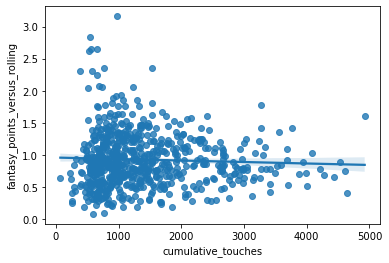

In [14]:
sns.regplot(x='cumulative_touches', y='fantasy_points_versus_rolling', data=df)

<AxesSubplot:xlabel='cumulative_touches', ylabel='points_per_game_versus_rolling'>

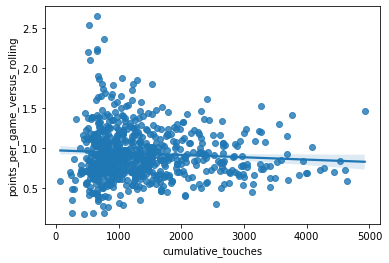

In [19]:
sns.regplot(x='cumulative_touches', y='points_per_game_versus_rolling', data=df)

<AxesSubplot:xlabel='cumulative_touches', ylabel='cumulative_games_missed'>

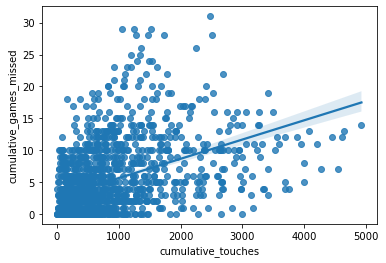

In [15]:
sns.regplot(x='cumulative_touches', y='cumulative_games_missed', data=df)

<AxesSubplot:xlabel='touches_bin', ylabel='fantasy_points_versus_rolling'>

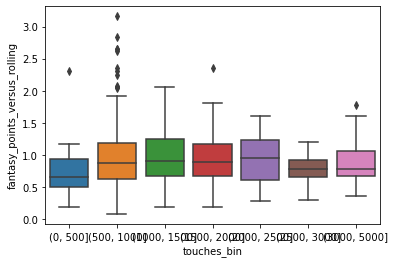

In [16]:
sns.boxplot(x='touches_bin', y='fantasy_points_versus_rolling', data=df)

<AxesSubplot:xlabel='touches_bin', ylabel='points_per_game_versus_rolling'>

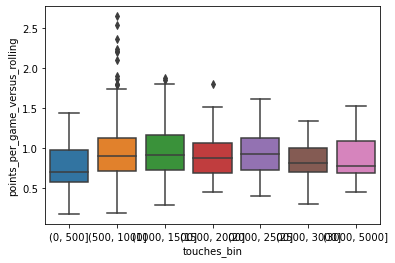

In [20]:
sns.boxplot(x='touches_bin', y='points_per_game_versus_rolling', data=df)

<AxesSubplot:xlabel='touches_bin', ylabel='cumulative_games_missed'>

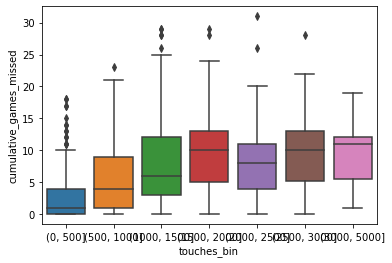

In [17]:
sns.boxplot(x='touches_bin', y='cumulative_games_missed', data=df)